<a href="https://colab.research.google.com/github/alessiodevoto/notebooks/blob/main/A_Primer_on_Explainability_for_GNNs_(Liverpool).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Primer on Explainability for GNNs

**Author**: [Alessio Devoto](https://alessiodevoto.github.io/)

This is an introductory tutorial to Explainable AI methods for Graph Neural Networks. It shows an application of [GNNExplainer](https://arxiv.org/abs/1903.03894) and some experiments with [Captum](https://captum.ai/). The notebook is partly inspired by [this](https://colab.research.google.com/drive/1fLJbFPz0yMCQg81DdCP5I8jXw9LoggKO?usp=sharing#scrollTo=PzX9xwFxCTff) introductory notebook  and [Simone Scardapane](https://sscardapane.it/)'s material on GNNs.



🔴 Change runtime for GPU

## 1. 🚗 Setup the colab environment

In [ ]:
%%capture
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install pytorch-lightning captum --quiet

In [ ]:
# GPU support
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
# !pip install torch_geometric
# !pip install pytorch-lightning captum --quiet

In [ ]:
# PyTorch imports
import torch
from torch.nn import functional as F

In [ ]:
# PyTorch-related imports
import torch_geometric as ptgeom
import torch_scatter, torch_sparse
import pytorch_lightning as ptlight
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy

In [ ]:
# Other imports
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split

In [ ]:
# PyG explainability
from torch_geometric.explain import Explainer, GNNExplainer
# Captum
from captum.attr import IntegratedGradients
from captum.influence import TracInCP, TracInCPFast

In [ ]:
matplotlib.rcParams['figure.dpi'] = 120 # I like higher resolution plots :)

In [ ]:
# We use the usual function for plotting molecules.

# This one is copy-pasted from: https://colab.research.google.com/drive/1fLJbFPz0yMCQg81DdCP5I8jXw9LoggKO?usp=sharing
import networkx as nx
import numpy as np
from torch_geometric.utils import to_networkx
from matplotlib.pyplot import figure

# transform the pytorch geometric graph into networkx format
def to_molecule(data: ptgeom.data.Data) -> nx.classes.digraph.DiGraph:
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g

# plot the molecule
def draw_molecule(g, edge_mask=None, draw_edge_labels=True, draw_node_labels=True, ax=None, figsize=None):
    figure(figsize = figsize or (4, 3))

    # check if it's been already converted to a nx graph
    if not isinstance(g, nx.classes.digraph.DiGraph):
      g = to_molecule(g)

    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels if draw_node_labels else None, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red', ax=ax)

    if ax is None:
      plt.show()


## 2. ⏩ Download Data & Train (we did this yesterday already)



In order to explain a model, we first need ... a model 😀.

We are going to train the same model as yesterday and store checkpoints in colab.

***Simply run all the cells in this section to train the model we will use for our explainers.***


In [ ]:
# Dataset
mutag = ptgeom.datasets.TUDataset(root='.', name='Mutagenicity')

# First, we split the original dataset into a training and test spart with a stratified split on the class
train_idx, test_idx = train_test_split(range(len(mutag)), stratify=[m.y[0].item() for m in mutag], test_size=0.25, random_state=11)
mutag_train = mutag[train_idx]
mutag_test = mutag[test_idx]


# Build the two loaders
train_loader = ptgeom.loader.DataLoader(mutag[train_idx], batch_size=32, shuffle=True)
test_loader = ptgeom.loader.DataLoader(mutag[test_idx], batch_size=32)

Extracting ./Mutagenicity/Mutagenicity.zip
Processing...
Done!


In [ ]:
# Define the Pytorch Lightning model

train_losses = []
eval_accs = []

class MUTAGClassifier(ptlight.LightningModule):

  def __init__(self, hidden_features: int):
    super().__init__()
    self.gc1 = ptgeom.nn.GCNConv(mutag.num_features, hidden_features)
    self.gc2 = ptgeom.nn.GCNConv(hidden_features, hidden_features)      # two "hops" seems enough for these small graphs
    self.gc3 = ptgeom.nn.GCNConv(hidden_features, hidden_features)
    self.gc4 = ptgeom.nn.GCNConv(hidden_features, hidden_features)
    self.pre_head = torch.nn.Linear(hidden_features, hidden_features)
    self.head = torch.nn.Linear(hidden_features, 1)                     # binary classification

  def forward(self, x, edge_index=None, batch=None, edge_weight=None):

    # unwrap the graph if the whole graph was passed
    if edge_index is None:
      x, edge_index, batch = x.x, x.edge_index, x.batch

    # GNN layers
    x = self.gc1(x, edge_index, edge_weight)
    x = F.relu(x)
    x = self.gc2(x, edge_index, edge_weight)
    x = F.relu(x)
    x = self.gc3(x, edge_index, edge_weight)
    x = F.relu(x)
    x = self.gc4(x, edge_index, edge_weight)
    x = F.relu(x)

    x = ptgeom.nn.global_mean_pool(x, batch) # now it's batch_size x embedding_dim
    x = F.dropout(x, p=0.5)
    x = self.pre_head(x)
    logits = self.head(x)

    return logits

  def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
      return optimizer


  def training_step(self, batch, _):

      logits = self.forward(batch.x, batch.edge_index, batch.batch)
      target = batch.y.unsqueeze(1)
      loss = F.binary_cross_entropy_with_logits(logits, target.float())

      self.log("train_loss", loss)
      self.log("train_accuracy", accuracy(logits, target, task='binary'), prog_bar=True, batch_size=32)
      train_losses.append(loss.detach())
      return loss

  def validation_step(self, batch, _):

    logits = self.forward(batch.x, batch.edge_index, batch.batch)
    target = batch.y.unsqueeze(1)
    loss = F.binary_cross_entropy_with_logits(logits, target.float())

    self.log("eval_accuracy", accuracy(logits, target, task='binary'), prog_bar=True, batch_size=32)
    eval_accs.append(accuracy(logits, target, task='binary'))

model = MUTAGClassifier(hidden_features=256)

In [ ]:
# We save checkpoints every 50 epochs
checkpoint_callback = ptlight.callbacks.ModelCheckpoint(
    dirpath='./checkpoints/',
    filename='gnn-v2-{epoch:02d}',
    every_n_epochs=50,
    save_top_k=-1)

In [ ]:
# Trainer and logs
trainer = ptlight.Trainer(max_epochs=100, callbacks=[checkpoint_callback])

# Train
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type    | Params
-------------------------------------
0 | gc1      | GCNConv | 3.8 K 
1 | gc2      | GCNConv | 65.8 K
2 | gc3      | GCNConv | 65.8 K
3 | gc4      | GCNConv | 65.8 K
4 | pre_head | Linear  | 65.8 K
5 | head     | Linear  | 257   
-------------------------------------
267 K     Trainable params
0         Non-trainable params
267 K     Total params
1.069     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


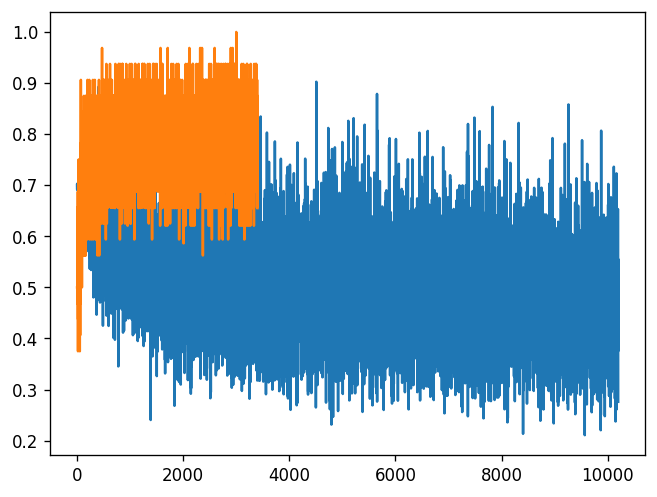

In [ ]:
plt.plot([x.detach().item() for x in train_losses])
plt.plot([x.detach().item() for x in eval_accs])

## 3. 🤷 Explainability

Awesome! Now we have a model to explain.

The zoo of explainability techniques for Neural Networks is quite crowded.

Before we go on, it is crucial to underline that 'interpretability' is an umbrella term that we use to refer to any method that tries to explain an ML model. Unfortunately, there is not an agreed and shared taxonomy for such methods.

The meaning of *explanation* is not universal and depends on the chosen method and on what we are trying to explain.

Are we trying to interpret how much a single example is influential for the training? Are we trying to explain how much each input feature affects the the prediction?

For an intro to Interpretability, see [this paper](https://arxiv.org/pdf/1606.03490.pdf) or [this book](https://christophm.github.io/interpretable-ml-book/taxonomy-of-interpretability-methods.html).

![](https://blog.paperspace.com/content/images/2022/02/recommender.png)




### 3.1 GNNExplainer

GNNExplainer is a simple method to search for instance-level explanations on a trained GNN. It optimizes for the smallest feature and edge masks that do not vary the prediction of the trained model.

See the full explanation in the original paper: https://arxiv.org/pdf/1903.03894.pdf

In [ ]:
# Same Data as yesterday. Take a look at the model we have just trained
print(mutag)
print(mutag_train)
print(model)

Mutagenicity(4337)
Mutagenicity(3252)
MUTAGClassifier(
  (gc1): GCNConv(14, 256)
  (gc2): GCNConv(256, 256)
  (gc3): GCNConv(256, 256)
  (gc4): GCNConv(256, 256)
  (pre_head): Linear(in_features=256, out_features=256, bias=True)
  (head): Linear(in_features=256, out_features=1, bias=True)
)


As GNNExplainer is an instance-level method, let us first pick a graph and the corresponding prediction.

In [ ]:
# we pick a graph from the mutagenic ones
# mutagenic graphs have label 0 in this Dataset
mutagenic_graphs = [x for x in mutag_test if x.y.item() == 0]
len(mutagenic_graphs)


601

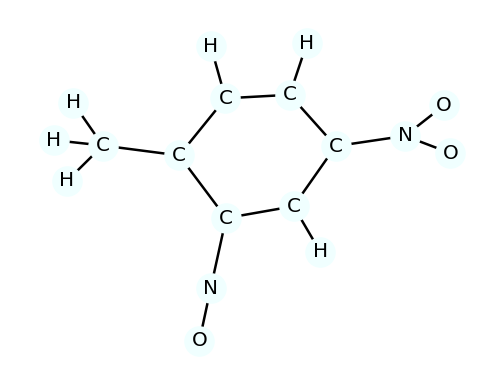

In [ ]:
# get a mutagenic graph
# Notice that the NO^2 group is known to cause mutagenicity

test_graph = mutagenic_graphs[7]
draw_molecule(test_graph)

In [ ]:
# Does the model work on this ? Apply activation with F.sigmoid https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/2880px-Logistic-curve.svg.png
model.eval()
model(test_graph.x, test_graph.edge_index)

tensor([[-3.9898]], grad_fn=<AddmmBackward0>)

In [ ]:
# Define the Explainer here
# See full API here https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.explain.algorithm.GNNExplainer.html
# and here https://pytorch-geometric.readthedocs.io/en/latest/modules/explain.html#torch_geometric.explain.Explainer

explainer = Explainer(
    algorithm=GNNExplainer(),
    model = model,
    explanation_type = 'model' ,
    node_mask_type = 'object' ,
    edge_mask_type = 'object' ,
    model_config = dict(
        mode = 'binary_classification',
        task_level = 'graph',
        return_type = 'raw'
    )
  )

In [ ]:
# Get the explanation, provide x and edge_index
explanation = explainer(test_graph.x, test_graph.edge_index)

In [ ]:
# Explanation is just a mask on the edges and nodes. Here we care mostly about the edges
# Print the explanation
print(explanation)

Explanation(node_mask=[18, 1], edge_mask=[36], prediction=[1, 1], target=[1], x=[18, 14], edge_index=[2, 36])


In [ ]:
# Which edges are the most important ?
explanation.edge_mask

tensor([0.2584, 0.1787, 0.8437, 0.1630, 0.1813, 0.7312, 0.8275, 0.8149, 0.7357,
        0.7778, 0.3999, 0.8268, 0.2077, 0.8015, 0.2284, 0.8166, 0.6703, 0.2156,
        0.7153, 0.7420, 0.6493, 0.7822, 0.2475, 0.2169, 0.6405, 0.1637, 0.2273,
        0.7522, 0.8361, 0.6988, 0.8057, 0.7544, 0.8347, 0.2674, 0.8695, 0.1976])

In [ ]:
# Get the highest values for each edge
topk_vals, topk_indices = explanation.edge_mask.topk(5)
print(topk_vals)
print(topk_indices)

tensor([0.8695, 0.8437, 0.8361, 0.8347, 0.8275])
tensor([34,  2, 28, 32,  6])


In [ ]:
# Create a subgraph from non masked edges, no need for utility functions
subgraph_explaination = ptgeom.data.Data(x=test_graph.x, edge_index=test_graph.edge_index[:, topk_indices])
print(subgraph_explaination)

Data(x=[18, 14], edge_index=[2, 5])


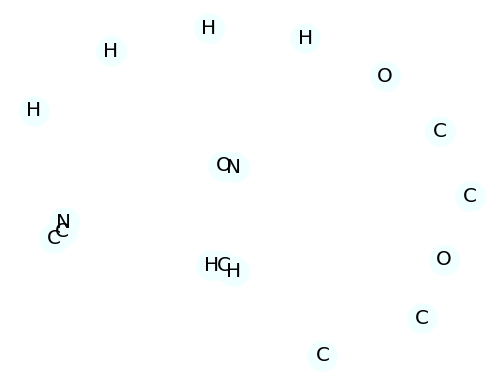

In [ ]:
# It has a lot of isolated nodes, right ?
draw_molecule(subgraph_explaination)

In [ ]:
# And remove isolated nodes
subgraph_explaination = ptgeom.transforms.RemoveIsolatedNodes()(subgraph_explaination)

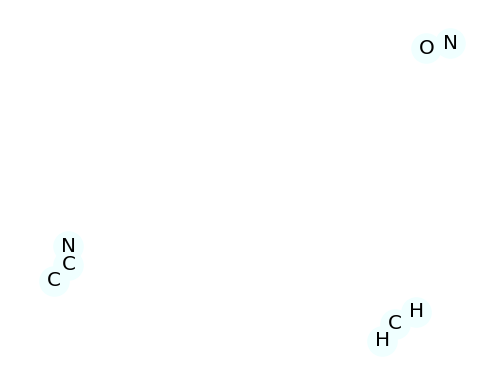

In [ ]:
# Plot the explanation
draw_molecule(subgraph_explaination)

### 3.2 💪 Exercise: Saliency for GNNs

Can we build a ***home made*** explainer, by just looking at the gradients that flow through the model ?

Many  attribution methods leverage the magnitude of the gradients with respect to input features, in order to estimate how important those features are for the output.
This is the case of saliency maps in Computer Vision.

In other words, they compute the importance of a feature $k_i$ like :

$$
Attribution_{k_i} = |\frac{\partial F(x)}{\partial k_i}|
$$




![](https://www.kitware.com/main/wp-content/uploads/2021/12/Kitware_SailencyImageClassification-1.png)

**Can we do the same for graphs nodes ?**

$$
Attribution_{n_i} = |\frac{\partial F(x)}{\partial n_i}|
$$

**Exercise:** Build a Saliency Map for `test_graph`.

Hint:
1. Get the prediction for the `test_graph`
2. Compute the gradient wrt the nodes.
3. Create a subgraph by filtering out the nodes which have a small gradient (you decide what 'small' means)
4. The subgraph will be our explanation!

In [ ]:
# Compute prediction
model.eval()
out = model(test_graph.x.requires_grad_(True), test_graph.edge_index)

In [ ]:
# Compute gradients
out.backward()

In [ ]:
# Get the gradients for the nodes
# Notice that the shape of the gradients will be same as that of node features, so you need
# rearrange in a nice way, e.g. summing them together
importance = test_graph.x.grad
print(importance.shape)
importance = importance.sum(dim=1)
print(importance.shape)

torch.Size([18, 14])
torch.Size([18])


In [ ]:
# Select topk nodes with highest value
# Hint: use torch.topk() method
topk_nodes, topk_indices = importance.topk(k=5)

In [ ]:
# Create a new subgraph from the topk nodes
# To compute the new edge indices have a look at this: https://pytorch-geometric.readthedocs.io/en/2.0.3/modules/utils.html#torch_geometric.utils.subgraph
new_edge_index, _ = ptgeom.utils.subgraph(subset=topk_indices, edge_index=test_graph.edge_index, relabel_nodes=True)

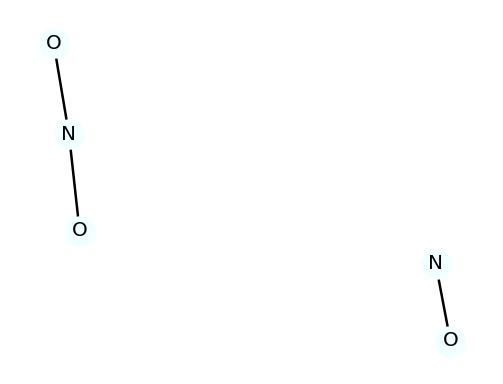

In [ ]:
# Draw the explanation
my_explanation = ptgeom.data.Data(x=test_graph.x[topk_indices, :], edge_index=new_edge_index)
draw_molecule(my_explanation)

### 3.2 Integrated gradients

[Integrated gradients](https://arxiv.org/abs/1703.01365) is a model-agnostic instance-level interpretability method.

The [idea](https://medium.com/@kemalpiro/xai-methods-integrated-gradients-6ee1fe4120d8) of Integrated Gradients is to integrate a "saliency vector" moving from a graph with no connectivity to our actual graph. As we interpolate from the initial empty graph to our test graph, we will observe the gradient with respect to some of the features changes more, meaning those features are more important for the classification.

$$
Attribution_{e_i} = \int_{\alpha =0}^1 \frac{\partial F(x_{\alpha)}}{\partial w_{e_i}} d\alpha
$$


We will use [Captum](https://captum.ai/), a library which offers a rich toolset of explainable AI methods.

![dog](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*kS1eh-Ua5QYZ6oYo.png)

The Captum implementation requires a function, not a method, which accepts the model and the mask with respect to which we must differentiate.


In [ ]:
 # All nodes belong to the same graph, so we create a 'fake' batch index
batch_idx = torch.zeros(test_graph.x.shape[0], dtype=torch.int64)

In [ ]:
# Initialize the edge mask and a beseline of zeros
edge_mask = torch.ones( test_graph.edge_index.shape[1], requires_grad=True).unsqueeze(0)
baseline = torch.zeros_like(edge_mask)

In [ ]:
# We just define a custom function whose input is the edge mask

model.eval()
def model_forward(edge_mask):
    # we must use the edge weight this time!
    out = model(test_graph.x, test_graph.edge_index, batch_idx, edge_mask[0])
    return out

In [ ]:
# Define integrated gradients like IntegratedGradients from https://captum.ai/api/integrated_gradients.html
ig = IntegratedGradients(model_forward)

In [ ]:
# Compute attribution with ig.attribute. We need the edge mask and the internal_batch_size
mask = ig.attribute(edge_mask, baselines=baseline, internal_batch_size=1).squeeze()

In [ ]:
mask

tensor([-0.6449, -0.3361,  3.8712,  0.0989,  0.0645, -1.3044, -0.1375, -0.6515,
        -0.6566, -0.2571, -2.2255, -0.4990, -0.6803,  2.4647,  0.1809, -0.2119,
        -1.3138,  0.9787, -0.8743, -0.8743, -0.8743,  1.7092,  0.1505, -0.2354,
        -1.2758, -0.0169, -1.1582, -1.1582,  2.0886,  2.0886,  2.3083,  2.4643,
         1.0209,  1.0209,  1.0209,  2.3862], dtype=torch.float64,
       grad_fn=<SqueezeBackward0>)

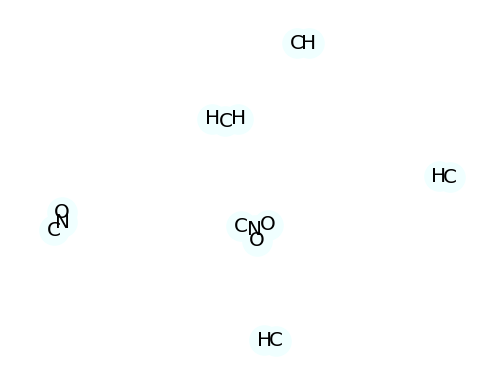

In [ ]:
# This is identical to before, using the new mask
topk_edges, topk_indices = mask.topk(10)

explanation = ptgeom.data.Data(x=test_graph.x, edge_index=test_graph.edge_index[:, topk_indices])
explanation = ptgeom.transforms.RemoveIsolatedNodes()(explanation)
draw_molecule(explanation)

### 3.3 TracIn

[TracIn](https://arxiv.org/pdf/2002.08484.pdf) is an explainability method which computes the influence of training examples on the prediction of test examples.

As you probably noticed, **the purpose of TracIn is quite different from the one of the other intepretability methods we saw so far**.

The main idea behind TracIn is to compute how much the prediction accuracy for a test graph changes when we train the model on a specific train graph.

In [ ]:
# We are going to need those checkpoints
!ls checkpoints

'gnn-v2-epoch=49.ckpt'	'gnn-v2-epoch=99.ckpt'


In [ ]:
# Manually create a list of checkpoints
checkpoints = ['checkpoints/gnn-v2-epoch=49.ckpt' , 'checkpoints/gnn-v2-epoch=99.ckpt']

In [ ]:
# print model
model

MUTAGClassifier(
  (gc1): GCNConv(14, 256)
  (gc2): GCNConv(256, 256)
  (gc3): GCNConv(256, 256)
  (gc4): GCNConv(256, 256)
  (pre_head): Linear(in_features=256, out_features=256, bias=True)
  (head): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
# We only compute the gradients for the last layer parameters
last_layer_dim = model.head.weight.shape[1]
print(last_layer_dim)

256


In [ ]:
# We will store the gradients here

test_grads = torch.zeros(len(checkpoints), last_layer_dim)
train_grads = torch.zeros(len(mutag_train), len(checkpoints), last_layer_dim)

In [ ]:
# Compute gradient at checkpints for test sample

for i in range(len(checkpoints)):

  # Load checkpoint
  ckpt = torch.load(checkpoints[i])
  model.load_state_dict(ckpt['state_dict'])

  # Model should be in eval mode
  model.eval()

  # Compute output and gradients
  out = model(test_graph)

  # Compute gradient of out wrt model weight
  grads = torch.autograd.grad(out, model.head.weight)[0]

  # Fill int the test_gradients
  test_grads[i] = grads



In [ ]:
# Compute gradient at checkpoints for train samples

for i in range(len(checkpoints)):

  # Load checkpoint
  ckpt = torch.load(checkpoints[i])
  model.load_state_dict(ckpt['state_dict'])

  # Model should be in eval mode
  model.eval()

  # Compute gradients for each graph
  for sample in range(len(train_idx)):
    out = model(mutag_train[i].x, mutag_train[i].edge_index)

    # Compute gradient of out wrt model weight
    grad = torch.autograd.grad(out, model.head.weight)[0]

    # Fill int the per sample train_gradients
    train_grads[sample][i] = grad


In [ ]:
# Compute TracIn scores

# test_grads  ( , 2, 256)
# train_grads (n, 2, 256 )
# we have to sum 1st and 2nd dims

relevance = (train_grads * test_grads).sum([1,2])

In [ ]:
# Which training graphs were the most influential ?


In [ ]:
# Test graph from before
print('Label:', test_graph.y.item())
draw_molecule(test_graph)

In [ ]:
# Print proponents

In [ ]:
# Print opponents
